# Tarea 4: Redes Convolucionales <br/> CC6204 Deep Learning, Universidad de Chile <br/> Hoja de Respuestas

## Nombre: Matias Cornejo
Fecha de entrega: 3 de diciembre

In [ ]:
import os
import sys
import random
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.spatial import distance

import torchvision
import torchvision.transforms as transforms

# Aqui descargamos algunas funciones utiles para resolver la tarea
if not os.path.exists('utils.py'):
  !wget https://raw.githubusercontent.com/dccuchile/CC6204/master/2020/tareas/tarea4/utils.py

from utils import ImageCaptionDataset, train_for_classification, train_for_retrieval

--2021-12-04 06:04:52--  https://raw.githubusercontent.com/dccuchile/CC6204/master/2020/tareas/tarea4/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7403 (7.2K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   7.23K  --.-KB/s    in 0s      

2021-12-04 06:04:52 (98.1 MB/s) - ‘utils.py’ saved [7403/7403]



In [ ]:
# Aqui instalamos la libreria de correccion del curso
!pip install -U "git+https://github.com/dccuchile/CC6204.git@master#egg=cc6204&subdirectory=autocorrect"
from timeit import default_timer as timer

# importamos las herramientas del curso
from cc6204 import AutoCorrect, FailedTest

# En caso que se les indique, cambia el host y port que posteamos en u-cursos
corrector = AutoCorrect(host="cc6204.dcc.uchile.cl", port=443)

# En caso que se les indique, cambia el token que te daremos en u-cursos
token = "]ye/Ox;nsz"

  Cloning https://github.com/dccuchile/CC6204.git (to revision master) to /tmp/pip-install-6kja5q66/cc6204_674f2f28ab60491c992141ca6e3d27cb
  Running command git clone -q https://github.com/dccuchile/CC6204.git /tmp/pip-install-6kja5q66/cc6204_674f2f28ab60491c992141ca6e3d27cb
  Created wheel for cc6204: filename=cc6204-0.5.0-py3-none-any.whl size=5800 sha256=efd259456962975850358079f7e5c23287548e995deb9d6243aa5475ed9e2d94
  Stored in directory: /tmp/pip-ephem-wheel-cache-5hzcfet8/wheels/3c/26/f5/2abeb546c3ff1ab6e69113a3ae69bc0ac3442642727fd0dcc2
Successfully built cc6204
Connection stablished


In [ ]:
corrector = AutoCorrect(host="cc6204.dcc.uchile.cl", port=443)

Connection stablished


In [ ]:
import matplotlib.pyplot as plt

def plot_results(loss, score1, score1_title='Accuracy', score2=None, score2_title=None):
  f1 = plt.figure(1)
  ax1 = f1.add_subplot(111)
  ax1.set_title("Loss")
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss')
  ax1.plot(loss, c='r')
  ax1.legend(['train-loss'])
  f1.show()

  f2 = plt.figure(2)
  ax2 = f2.add_subplot(111)
  ax2.set_title(score1_title)
  ax2.set_xlabel('epochs')
  ax2.set_ylabel(score1_title.lower())
  ax2.plot(score1[0], c='b')
  ax2.plot(score1[1], c='g')
  ax2.legend([f'train-{score1_title.lower()}', f'val-{score1_title.lower()}'])
  f2.show()

  if score2:
    f3= plt.figure(3)
    ax3 = f3.add_subplot(111)
    ax3.set_title(score2_title)
    ax3.set_xlabel('epochs')
    ax3.set_ylabel(score2_title.lower())
    ax3.plot(score2[0], c='b')
    ax3.plot(score2[1], c='g')
    ax3.legend([f'train-{score2_title.lower()}', f'val-{score2_title.lower()}'])
    f3.show()

# Parte 1: Arquitectura Convolucional GoogLeNet (y otras) para CIFAR10

## 1a) Inception Module

In [ ]:
class InceptionModule(nn.Module):
  def __init__(self,
               in_channels,
               ch_3x3_reduce=96,
               ch_5x5_reduce=16,
               ch_3x3=128,
               ch_5x5=32,
               ch_pool_proj=32,
               ch_1x1=64
    ):
    super(InceptionModule, self).__init__()
    #Tamaño input (B,C,32,32)
    #Inception module with dimension reductions
    #D1
    self.D1 = nn.Sequential(nn.Conv2d(in_channels, ch_3x3_reduce, (1,1), stride=1, padding=0), #self.conv_1p1_reduce_3p3
                            nn.BatchNorm2d(ch_3x3_reduce),
                            nn.ReLU(True),
                            nn.Conv2d(ch_3x3_reduce, ch_3x3, (3,3), stride=1, padding=1), #self.conv_3p3
                            nn.BatchNorm2d(ch_3x3),
                            nn.ReLU(True)
    )

    #D2
    self.D2 = nn.Sequential(nn.Conv2d(in_channels, ch_5x5_reduce, (1,1), stride=1, padding=0), #self.conv_1p1_reduce_3p3
                            nn.BatchNorm2d(ch_5x5_reduce),
                            nn.ReLU(True),
                            nn.Conv2d(ch_5x5_reduce, ch_5x5, (5,5), stride=1, padding=2), #self.conv_3p3
                            nn.BatchNorm2d(ch_5x5),
                            nn.ReLU(True)
    )

    #D3
    self.D3 = nn.Sequential(nn.MaxPool2d((3,3), stride=1, padding = 1), #padding = 1 para mantener W,H
                            nn.Conv2d(in_channels, ch_pool_proj, (1,1), stride=1),
                            nn.BatchNorm2d(ch_pool_proj),
                            nn.ReLU(True)
    )

    #D4
    self.D4 = nn.Sequential(nn.Conv2d(in_channels, ch_1x1, (1,1), stride=1, padding=0),
                            nn.BatchNorm2d(ch_1x1),
                            nn.ReLU(True)
    )

  def forward(self, x):
    # Calcula la salida como un tensor con cantidad de canales de
    # salida dado por ch_3x3 + ch_5x5 + ch_pool_proj + ch_1x1
    #D1
    D1 = self.D1(x)
    #D2
    D2 = self.D2(x)
    #D3
    D3 = self.D3(x)
    #D4
    D4 = self.D4(x)

    return torch.cat([D1,D2,D3,D4], dim=1)

In [ ]:
# Tests del API del curso para el InceptionModule

# Obtengamos algunos parametros para probar tu implementación
x, in_chs, ch_1x1, ch_3x3_red, ch_3x3, ch_5x5_red, ch_5x5, ch_pool_proj = corrector.get_test_data(homework=4, question="1a", test=1, token=token)
# Corramos tu implementación de InseptionModule para ver como se comporta
with torch.no_grad():
  model = InceptionModule(in_chs, ch_3x3_red, ch_5x5_red, ch_3x3, ch_5x5, ch_pool_proj, ch_1x1)
  s = timer()
  result = model(torch.tensor(x))
  t = timer()-s

# Veamos si todo fue OK :)
corrector.submit(homework=4, question="1a", test=1, token=token, answer=list(result.size()), time=t)

Correct Test!


## 1b) GoogLeNet

In [ ]:
class GoogLeNet(nn.Module):
  def __init__(self, n_classes, use_aux_logits=True):
    super(GoogLeNet, self).__init__()

    # Define las capas de convolución y pooling de GoogLeNet
    self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool1 = nn.MaxPool2d(3, stride=1, ceil_mode=True, padding=1)
    self.conv2 = nn.Conv2d(64, 64, kernel_size=1)
    self.conv3 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
    self.maxpool2 = nn.MaxPool2d(3, stride=1, ceil_mode=True, padding=1)
    #(in_chs, ch_3x3_red, ch_5x5_red, ch_3x3, ch_5x5, ch_pool_proj, ch_1x1)
    self.inception3a = InceptionModule(192, 96, 16, 128, 32, 32, 64) #(192, 64, 96, 128, 16, 32, 32) (in_channels, ch1x1 ,ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj) (in_chs, ch_3x3_red, ch_5x5_red, ch_3x3, ch_5x5, ch_pool_proj, ch_1x1)
    self.inception3b = InceptionModule(256, 128, 32, 192, 96, 64, 128) #(256, 128, 128, 192, 32, 96, 64)
    self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
    self.inception4a = InceptionModule(480, 96, 16, 208, 48, 64, 192)
    self.inception4b = InceptionModule(512, 112, 24, 224, 64, 64, 160) #luego del 4b primer aux
    self.inception4c = InceptionModule(512, 128, 24, 256, 64, 64, 128)
    self.inception4d = InceptionModule(512, 144, 32, 288, 64, 64, 112) #luego del 4d segundo aux
    self.inception4e = InceptionModule(528, 160, 32, 320, 128, 128, 256)
    self.maxpool4 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

    self.inception5a = InceptionModule(832, 160, 32, 320, 128, 128, 256)
    self.inception5b = InceptionModule(832, 192, 48, 384, 128, 128, 384)

    # Decide si usar la clasificación auxiliar
    self.use_aux_logits = use_aux_logits
    if self.use_aux_logits:
      self.aux_avgpool1 = nn.AvgPool2d(5, stride=3) #torch.nn.functional.adaptive_avg_pool2d
      self.aux_conv1 = nn.Conv2d(512, 128, kernel_size=1)
      self.aux_fc1_1 = nn.Linear(2048, 1024)
      self.aux_fc2_1 = nn.Linear(1024, n_classes)
      self.aux_dropout1 = nn.Dropout(p=0.7)

      self.aux_avgpool2 = nn.AvgPool2d(5, stride=3) #torch.nn.functional.adaptive_avg_pool2d
      self.aux_conv2 = nn.Conv2d(528, 128, kernel_size=1)
      self.aux_fc1_2 = nn.Linear(2048, 1024)
      self.aux_fc2_2 = nn.Linear(1024, n_classes)
      self.aux_dropout2 = nn.Dropout(p=0.7)

    # Capa de salida (antes de la función de salida)

    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.dropout = nn.Dropout(p=0.4)

    self.fc_out = nn.Linear(1024, n_classes)

  def forward(self, x):
    # Crea una lista para los logits auxiliares si fuera necesario
    if self.use_aux_logits and self.training:
      aux_logits = []
    else:
      aux_logits = None

    # Computa las representaciones internas de la red
    #[5, 3, 32, 32]
    x = self.conv1(x)
    x = self.relu(x)
    #[5, 64, 32, 32]
    x = self.maxpool1(x)
    #[5, 64, 32, 32]
    x = self.conv2(x)
    x = self.relu(x)
    #[5, 64, 32, 32]
    x = self.conv3(x)
    x = self.relu(x)
    #[5, 64, 32, 32]
    x = self.maxpool2(x)
    #[5, 192, 32, 32]
    x = self.inception3a(x)
    #[5, 208, 32, 32]
    x = self.inception3b(x)
    #[5, 480, 32, 32]
    x = self.maxpool3(x)
    #[5, 480, 16, 16]
    x = self.inception4a(x)
    #[5, 512, 16, 16]


    # Si se usa la clasificación auxiliar, computa logits auxiliares
    if self.use_aux_logits and self.training:
      aux_logit_1 = self.aux_avgpool1(x)
      aux_logit_1 = self.aux_conv1(aux_logit_1)
      aux_logit_1 = nn.functional.relu(aux_logit_1, inplace=True)
      aux_logit_1 = torch.flatten(aux_logit_1, 1)
      aux_logit_1 = self.aux_fc1_1(aux_logit_1)
      aux_logit_1 = nn.functional.relu(aux_logit_1, inplace=True)
      aux_logit_1 = self.aux_dropout1(aux_logit_1)
      aux_logit_1 = self.aux_fc2_1(aux_logit_1)

      # Agrégalo a la lista de logits auxiliares
      aux_logits.append(aux_logit_1)

    # Continúa computando las representaciones internas de la red
    x = self.inception4b(x)
    #[5, 512, 16, 16]
    x = self.inception4c(x)
    #[5, 512, 16, 16]
    x = self.inception4d(x)
    #[5, 528, 16, 16]

    # Si se usa la clasificación auxiliar, computa logits auxiliares
    aux_logit_2 = None
    if self.use_aux_logits and self.training:
      aux_logit_2 = self.aux_avgpool2(x)
      aux_logit_2 = self.aux_conv2(aux_logit_2)
      aux_logit_2 = nn.functional.relu(aux_logit_2, inplace=True)
      aux_logit_2 = torch.flatten(aux_logit_2, 1)
      aux_logit_2 = self.aux_fc1_2(aux_logit_2)
      aux_logit_2 = nn.functional.relu(aux_logit_2, inplace=True)
      aux_logit_2 = self.aux_dropout2(aux_logit_2)
      aux_logit_2 = self.aux_fc2_2(aux_logit_2)
      # Agrégalo a la lista de logits auxiliares
      aux_logits.append(aux_logit_2)

    # Continúa computando las representaciones internas de la red
    x = self.inception4e(x)
    #[5, 832, 16, 16]
    x = self.maxpool4(x)
    #[5, 832, 8, 8]
    x = self.inception5a(x)
    #[5, 832, 8, 8]
    x = self.inception5b(x)
    #[5, 1024, 8, 8]

    x = self.avgpool(x)
    #[5, 1024, 1, 1]
    x = torch.flatten(x, 1)
    #[5, 1024]
    x = self.dropout(x)
    hidden = x
    #[5, 1024]
    # N x out_size
    logits = self.fc_out(x)
    #[5, 25]

    # En hidden debes devolver alguna de las capas oculta de la red
    return {'hidden': hidden, 'logits': logits, 'aux_logits': aux_logits}

In [ ]:
# Tests del API del curso para el InceptionModule

# Obtengamos algunos parametros para probar tu implementación
x, n_classes, use_aux_logits = corrector.get_test_data(homework=4, question="1b", test=1, token=token)

# Corramos tu implementación de InseptionModule para ver como se comporta
with torch.no_grad():
  model = GoogLeNet(n_classes=n_classes, use_aux_logits=use_aux_logits)
  s = timer()
  result = model(torch.tensor(x))
  t = timer()-s

# Veamos si todo fue OK :)
sizes = [result['hidden'].shape[0]] + list(result['logits'].size()) + [d for a in result['aux_logits'] for d in a.size()]
corrector.submit(homework=4, question="1b", test=1, token=token, answer=sizes, time=t)

Correct Test!


## 1c.1) Arquitectura Convolucional: ResNet50



In [ ]:
class BottleneckModule(nn.Module):
  expansion: int = 4
  def __init__(self, inplanes, planes=64, stride=1, downsample = None):

    super(BottleneckModule, self).__init__()



    self.conv1 = nn.Conv2d(inplanes, planes, (1,1), stride=1)
    self.bn1 = nn.BatchNorm2d(planes) #We adopt batch normalization (BN) right after each convolution and before activation
    self.conv2 = nn.Conv2d(planes, planes, (3,3), stride=stride, padding=1)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = nn.Conv2d(planes, planes * self.expansion, (1,1), stride=1)
    self.bn3 = nn.BatchNorm2d(planes * self.expansion)

    self.relu = nn.ReLU(inplace=True)

    self.downsample = downsample

  def forward(self, x):
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)

    if self.downsample is not None:
      identity = self.downsample(x)

    out += identity
    out = self.relu(out)

    return out

In [ ]:
# Acá el código para tu primera arquitectura

class ResNet50(nn.Module):
  def __init__(self, n_classes):
    super(ResNet50, self).__init__()

    self.inplanes = 64

    # Define las capas de convolución y pooling de tu arquitectura
    self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer1 = self._make_layer(64, 3)
    self.layer2 = self._make_layer(128, 4, stride=2)
    self.layer3 = self._make_layer(256, 6, stride=2)
    self.layer4 = self._make_layer(512, 3, stride=2)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    self.dropout = nn.Dropout(p=0.4)
    # Capa de salida (antes de la función de salida)
    self.fc_out = nn.Linear(512 * BottleneckModule.expansion, n_classes)

  def _make_layer(self, planes, blocks, stride=1):
    downsample = None
    if stride != 1 or self.inplanes != planes * BottleneckModule.expansion:
      downsample = nn.Sequential(
          nn.Conv2d(self.inplanes, planes * BottleneckModule.expansion, (1,1), stride),
          nn.BatchNorm2d(planes * BottleneckModule.expansion)
          )
    layers = []
    layers.append(BottleneckModule(self.inplanes, planes, stride, downsample))
    self.inplanes = planes * BottleneckModule.expansion
    for _ in range(1, blocks):
        layers.append(BottleneckModule(self.inplanes, planes))

    return nn.Sequential(*layers)

  def forward(self, x):
    # Computa las representaciones internas de la red
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.dropout(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    h = x

    x = self.avgpool(x)

    x = self.dropout(x)

    x = torch.flatten(x, 1)

    logits = self.fc_out(x)

    # En hidden debes devolver alguna de las capas oculta de la red
    return {'hidden': h, 'logits': logits}

## 1c.2) Arquitectura Convolucional: ResNet18



In [ ]:
class BuildingBlock(nn.Module):
  expansion: int = 1
  def __init__(self, inplanes, planes=64, stride=1, downsample = None):

    super(BuildingBlock, self).__init__()

    self.conv1 = nn.Conv2d(inplanes, planes, (3,3), stride=stride, padding=1)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, (3,3), stride=stride, padding=1)
    self.bn2 = nn.BatchNorm2d(planes)

    self.relu = nn.ReLU(inplace=True)

    self.downsample = downsample

  def forward(self, x):
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    if self.downsample is not None:
      identity = self.downsample(x)
    out += identity
    out = self.relu(out)

    return out

In [ ]:
# Acá el código para tu primera arquitectura

class ResNet18(nn.Module):
  def __init__(self, n_classes):
    super(ResNet18, self).__init__()

    self.inplanes = 64

    # Define las capas de convolución y pooling de tu arquitectura
    self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer1 = self._make_layer(64, 2)
    self.layer2 = self._make_layer(128, 2, stride=1)
    self.layer3 = self._make_layer(256, 2, stride=1)
    self.layer4 = self._make_layer(512, 2, stride=1)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    self.dropout = nn.Dropout(p=0.5)
    # Capa de salida (antes de la función de salida)
    self.fc_out = nn.Linear(512 * BuildingBlock.expansion, n_classes)

  def _make_layer(self, planes, blocks, stride=1):
    downsample = None
    if stride != 1 or self.inplanes != planes * BuildingBlock.expansion:
      downsample = nn.Sequential(
          nn.Conv2d(self.inplanes, planes * BuildingBlock.expansion, (1,1), stride),
          nn.BatchNorm2d(planes * BuildingBlock.expansion)
          )
    layers = []
    layers.append(BuildingBlock(self.inplanes, planes, stride, downsample))
    self.inplanes = planes * BuildingBlock.expansion
    for _ in range(1, blocks):
        layers.append(BuildingBlock(self.inplanes, planes))

    return nn.Sequential(*layers)

  def forward(self, x):
    # Computa las representaciones internas de la red
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    hidden = x

    x = self.dropout(x)

    x = torch.flatten(x, 1)

    logits = self.fc_out(x)

    # En hidden debes devolver alguna de las capas oculta de la red
    return {'hidden': hidden, 'logits': logits}

## 1d) Clasificación de Imágenes en CIFAR10

In [ ]:
##############################################################################
# Todo este código sirve para descargar, preprocesar y dejar los datos
# listos para usar después. Después de ejecutar las celdas tendrás los datos
# trainset, trainloader y similar para test.
##############################################################################

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 1d.1) GoogleNet en CIFAR10
Val_Acc = 87%

Epoch:1(50000/50000), lr:0.1000000, Loss:1.60736, Train Acc:40.4%, Validating..., Val Acc:49.80%, Avg-Time:135.609s.
Epoch:2(50000/50000), lr:0.1000000, Loss:1.22201, Train Acc:57.6%, Validating..., Val Acc:60.40%, Avg-Time:135.569s.
Epoch:3(50000/50000), lr:0.1000000, Loss:1.01729, Train Acc:66.4%, Validating..., Val Acc:63.16%, Avg-Time:135.568s.
Epoch:4(50000/50000), lr:0.1000000, Loss:0.87397, Train Acc:71.9%, Validating..., Val Acc:69.82%, Avg-Time:135.562s.
Epoch:5(50000/50000), lr:0.1000000, Loss:0.76540, Train Acc:76.4%, Validating..., Val Acc:69.94%, Avg-Time:135.564s.
Epoch:6(50000/50000), lr:0.1000000, Loss:0.67386, Train Acc:79.8%, Validating..., Val Acc:75.35%, Avg-Time:135.570s.
Epoch:7(50000/50000), lr:0.1000000, Loss:0.59996, Train Acc:82.2%, Validating..., Val Acc:74.11%, Avg-Time:135.581s.
Epoch:8(50000/50000), lr:0.0800000, Loss:0.50584, Train Acc:85.3%, Validating..., Val Acc:81.33%, Avg-Time:135.594s.
Epoch:9(50000/50000), lr:0.0800000, Loss:0.44876, Train Acc:87.2

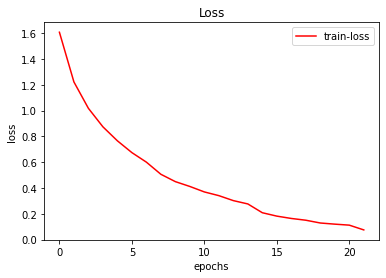

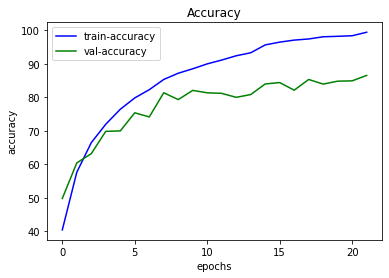

In [ ]:
#Dps de los relu
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# Definamos algunos hiper-parámetros
BATCH_SIZE = 128
LR = 0.1
EPOCHS = 22
REPORTS_EVERY = 1

net = GoogLeNet(n_classes=len(classes), use_aux_logits=True) # tu modelo de CNN (para clasificar en 10 clases)
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9) # Our training used asynchronous stochastic gradient descent with 0.9 momentum
criterion = nn.CrossEntropyLoss() # softmax loss as the classifier (torch CEL tiene nn.LogSoftmax() incluido)
scheduler = StepLR(optimizer, step_size=7, gamma=0.8) # fixed learning rate schedule (decreasing the learning rate by 4% every 8 epochs)

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=2)

train_loss, acc = train_for_classification(net, train_loader,
                                           test_loader, optimizer,
                                           criterion, lr_scheduler=scheduler,
                                           epochs=EPOCHS, reports_every=REPORTS_EVERY)

plot_results(train_loss, acc)

### 1d.2) ResNet50 en CIFAR10
Val_Acc = 60%

In [ ]:
# Definamos algunos hiper-parámetros
BATCH_SIZE = 128
LR = 0.1
EPOCHS = 40
REPORTS_EVERY = 1

net = ResNet50(n_classes=len(classes)) # tu modelo de CNN (para clasificar en 10 clases)
optimizer = optim.SGD(net.parameters(), lr=LR, weight_decay=0.0001, momentum=0.9) # optimizador, e.g., optim.SGD, optim.Adam, ...
criterion = nn.CrossEntropyLoss() # función de pérdida
scheduler = StepLR(optimizer, step_size=8, gamma=0.1) # (opcional) optim.lr_scheduler proporciona varios métodos para ajustar el lr según el número de épocas

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=2)

train_loss, acc = train_for_classification(net, train_loader,
                                           test_loader, optimizer,
                                           criterion, lr_scheduler=scheduler,
                                           epochs=EPOCHS, reports_every=REPORTS_EVERY)

plot_results(train_loss, acc)

### 1d.3) ResNet18 en CIFAR10
Val_Acc = 82% (No DropOut)

Epoch:1(50000/50000), lr:0.1000000, Loss:1.83690, Train Acc:35.1%, Validating..., Val Acc:42.84%, Avg-Time:19.204s.
Epoch:2(50000/50000), lr:0.1000000, Loss:1.31398, Train Acc:51.7%, Validating..., Val Acc:52.94%, Avg-Time:19.271s.
Epoch:3(50000/50000), lr:0.1000000, Loss:1.09084, Train Acc:60.6%, Validating..., Val Acc:61.12%, Avg-Time:19.331s.
Epoch:4(50000/50000), lr:0.1000000, Loss:0.93097, Train Acc:66.6%, Validating..., Val Acc:64.63%, Avg-Time:19.342s.
Epoch:5(50000/50000), lr:0.1000000, Loss:0.81167, Train Acc:71.6%, Validating..., Val Acc:71.02%, Avg-Time:19.317s.
Epoch:6(50000/50000), lr:0.1000000, Loss:0.71877, Train Acc:74.7%, Validating..., Val Acc:72.32%, Avg-Time:19.327s.
Epoch:7(50000/50000), lr:0.1000000, Loss:0.64113, Train Acc:77.4%, Validating..., Val Acc:74.71%, Avg-Time:19.301s.
Epoch:8(50000/50000), lr:0.1000000, Loss:0.57650, Train Acc:80.0%, Validating..., Val Acc:74.51%, Avg-Time:19.296s.
Epoch:9(50000/50000), lr:0.1000000, Loss:0.53476, Train Acc:81.3%, Valid

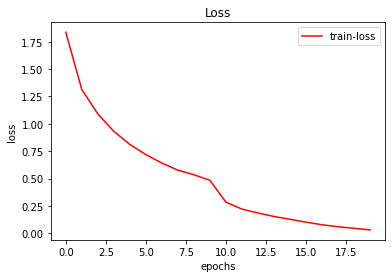

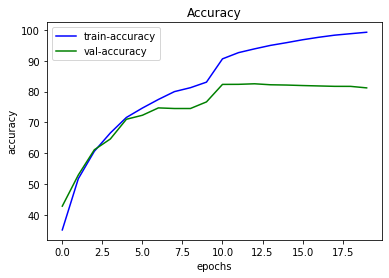

In [ ]:
# Definamos algunos hiper-parámetros
BATCH_SIZE = 128
LR = 0.1
EPOCHS = 20
REPORTS_EVERY = 1

net = ResNet18(n_classes=len(classes)) # tu modelo de CNN (para clasificar en 10 clases)
optimizer = optim.SGD(net.parameters(), lr=LR, weight_decay=0.0001, momentum=0.9) # optimizador, e.g., optim.SGD, optim.Adam, ...
criterion = nn.CrossEntropyLoss() # función de pérdida
scheduler = StepLR(optimizer, step_size=10, gamma=0.1) # (opcional) optim.lr_scheduler proporciona varios métodos para ajustar el lr según el número de épocas

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=2)

train_loss, acc = train_for_classification(net, train_loader,
                                           test_loader, optimizer,
                                           criterion, lr_scheduler=scheduler,
                                           epochs=EPOCHS, reports_every=REPORTS_EVERY)

plot_results(train_loss, acc)

### 1d.4) ResNet18 en CIFAR10
Val_Acc = 82% (1xDropOut = 0.4)

Epoch:1(50000/50000), lr:0.1000000, Loss:1.88541, Train Acc:32.2%, Validating..., Val Acc:42.50%, Avg-Time:19.355s.
Epoch:2(50000/50000), lr:0.1000000, Loss:1.38921, Train Acc:49.2%, Validating..., Val Acc:53.76%, Avg-Time:19.303s.
Epoch:3(50000/50000), lr:0.1000000, Loss:1.15914, Train Acc:58.3%, Validating..., Val Acc:58.13%, Avg-Time:19.224s.
Epoch:4(50000/50000), lr:0.1000000, Loss:0.98643, Train Acc:65.0%, Validating..., Val Acc:65.87%, Avg-Time:19.189s.
Epoch:5(50000/50000), lr:0.1000000, Loss:0.84266, Train Acc:70.3%, Validating..., Val Acc:69.74%, Avg-Time:19.197s.
Epoch:6(50000/50000), lr:0.1000000, Loss:0.74183, Train Acc:74.4%, Validating..., Val Acc:73.01%, Avg-Time:19.201s.
Epoch:7(50000/50000), lr:0.1000000, Loss:0.65831, Train Acc:77.1%, Validating..., Val Acc:73.03%, Avg-Time:19.204s.
Epoch:8(50000/50000), lr:0.1000000, Loss:0.58722, Train Acc:79.5%, Validating..., Val Acc:72.40%, Avg-Time:19.220s.
Epoch:9(50000/50000), lr:0.1000000, Loss:0.52545, Train Acc:81.7%, Valid

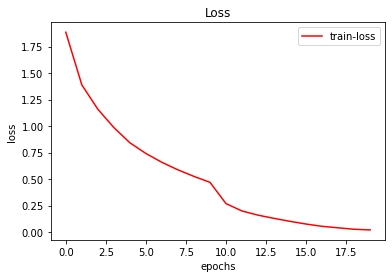

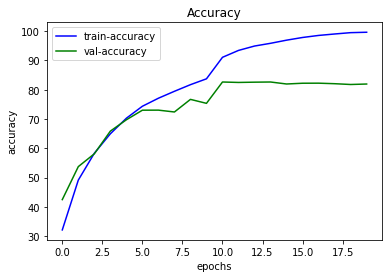

In [ ]:
BATCH_SIZE = 128
LR = 0.1
EPOCHS = 20
REPORTS_EVERY = 1

net = ResNet18(n_classes=len(classes)) # tu modelo de CNN (para clasificar en 10 clases)
optimizer = optim.SGD(net.parameters(), lr=LR, weight_decay=0.0001, momentum=0.9) # optimizador, e.g., optim.SGD, optim.Adam, ...
criterion = nn.CrossEntropyLoss() # función de pérdida
scheduler = StepLR(optimizer, step_size=10, gamma=0.1) # (opcional) optim.lr_scheduler proporciona varios métodos para ajustar el lr según el número de épocas

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=2)

train_loss, acc = train_for_classification(net, train_loader,
                                           test_loader, optimizer,
                                           criterion, lr_scheduler=scheduler,
                                           epochs=EPOCHS, reports_every=REPORTS_EVERY)

plot_results(train_loss, acc)

ResNet18 Funciona mejor que ResNet50 (hay menos overfit), esto tieen sentido ya que el dataset y las clases es muy pequeño para trabajar con tantas capas.

In [ ]:
# Test
x, y = list(test_loader)[0]
net.cpu()
net.eval()
y_pred = net(x)['logits'].max(dim=1)[1]

# Veamos como se comporta el modelo
print("Correct Test!" if (y==y_pred).sum()/len(x) >= .75 else "Failed Test! [acc]")

Correct Test!


## 1e) Opcional: CIFAR100

In [ ]:
##############################################################################
# Toda esta parte es similar a la anterior pero para CIFAR100.
##############################################################################

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR100(root='./data/cifar100', train=True,
                                         download=True, transform=transform)

testset = torchvision.datasets.CIFAR100(root='./data/cifar100', train=False,
                                        download=True, transform=transform)

In [ ]:
# Definamos algunos hiper-parámetros
BATCH_SIZE = ...
LR = ...
EPOCHS = ...
REPORTS_EVERY = 1

net = ... # tu modelo de CNN (para clasificar en 100 clases)
optimizer = ... # optimizador, e.g., optim.SGD, optim.Adam, ...
criterion = nn.CrossEntropyLoss() # función de pérdida
scheduler = ... # (opcional) optim.lr_scheduler proporciona varios métodos para ajustar el lr según el número de épocas

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=4*BATCH_SIZE,
                         shuffle=False, num_workers=2)

train_loss, acc = train_for_classification(net, train_loader,
                                           test_loader, optimizer,
                                           criterion, lr_scheduler=scheduler,
                                           epochs=EPOCHS, reports_every=REPORTS_EVERY)

plot_results(train_loss, acc)

# Parte 2: Subtitulado de Imágenes mediante Recuperación de Textos

## 2a) Codificación de Imágenes y Textos

In [ ]:
class ImageEncoding(nn.Module):
  def __init__(self, cnn_model, cnn_out_size, out_size=128, use_last_bn=True):
    super(ImageEncoding, self).__init__()
    self.cnn_model = cnn_model

    # Defina las capas de su MLP
    # Hints: no usar más de 3 capas
    #        incorpora alguna técnica de regularización que ya conoces
    self.fc1 = nn.Linear(cnn_out_size, 512)
    self.fc2 = nn.Linear(512, out_size)

    self.use_last_bn = use_last_bn

    if use_last_bn:
        self.bn = nn.BatchNorm1d(out_size)

    self.dropout = nn.Dropout(p=0.4)

  def forward(self, x):
    x = self.cnn_model(x)['hidden']

    # Compute las capas de su MLP out_dict = net(X) / out_dict = net(X)
    x = self.fc1(x)
    x = self.dropout(x)
    fc_out = self.fc2(x)

    if self.use_last_bn:
      fc_out = self.bn(fc_out)

    fc_out = F.relu(fc_out)
    # En fc_out debe almacenar el encoding en R^d
    return {'logits': fc_out}

In [ ]:
class TextEncoding(nn.Module):
  def __init__(self, text_embedding_size=4096, out_size=128, use_last_bn=True):
    super(TextEncoding, self).__init__()

    # Defina las capas de su MLP
    # Hints: no usar más de 3 capas
    #        incorpora alguna técnica de regularización que ya conoces
    self.fc1 = nn.Linear(text_embedding_size, 512)
    self.fc2 = nn.Linear(512, out_size)

    self.use_last_bn = use_last_bn

    if use_last_bn:
      self.bn = nn.BatchNorm1d(out_size)

    self.dropout = nn.Dropout(p=0.4)

  def forward(self, x):
    # Compute las capas de su MLP
    x = self.fc1(x)
    x = self.dropout(x)
    fc_out = self.fc2(x)

    if self.use_last_bn:
      fc_out = self.bn(fc_out)

    fc_out = F.relu(fc_out)
    # En logits debe almacenar el encoding en R^d
    return {'logits': fc_out}

In [ ]:
# Test
OUT_SIZE = 200

cnn_net = GoogLeNet(n_classes=10)
i_enc = ImageEncoding(cnn_model=cnn_net, cnn_out_size=1024, out_size=OUT_SIZE)
t_enc = TextEncoding(text_embedding_size=4096, out_size=OUT_SIZE)
i_enc.eval()
t_enc.eval()

# Veamos como se comportan tus encoders
print("Correct Test!" if (i_enc(torch.randn(9,3,32,32))['logits'].size()==t_enc(torch.randn(9,4096))['logits'].size()) else "Failed Test [size]")
print("Correct Test!" if (i_enc(torch.randn(9,3,32,32))['logits'].size(-1)==OUT_SIZE) else "Failed Test [size]")

Correct Test!
Correct Test!


## 2b) Buenas codificaciones y la *Triplet Loss*

In [ ]:
class TripletLoss(nn.Module):
  def __init__(self, margin=.2, negative='max'):
    super(TripletLoss, self).__init__()
    self.margin = margin
    self.negative = negative

  def forward(self, anchor, positive):
    # Posiblemente lo más simple es partir calculando la distancia Euclideana
    # entre las imagenes ancla y todos los pares (B x B) de representaciones
    # de textos (hint: usa torch.cdist)
    dists = torch.cdist(anchor, positive, p=2) #[10x10] distancia entre Ai y Pi

    # Obtener distancias "positivas" de la diagonal
    p_dists = dists.diagonal()
    p_dists = p_dists.unsqueeze(1).expand_as(dists) #[10x10] valores repetidos de diagonal p_dist = p_dist.unsqueeze(1).expand_as(dists)

    # Ahora genera un tensor con todos los costos
    # siguiendo la formula vista en la orientación de la tarea
    cost = p_dists - dists + self.margin
    cost = (cost).clamp(min=0).fill_diagonal_(0)

    # Ahora genera un tensor con todos los costos que se deben agregar
    # dependiendo de la forma de encontrar los negativos
    if self.negative == 'max':
      cost = torch.tensor([torch.max(i) for i in cost])

    elif self.negative == 'random':
      # creamos tansor con los pesos para hacer la selección elatoria
      # (una matriz con 1 en todas las posiciones, excepto la diagonal)
      weight = torch.ones_like(cost).fill_diagonal_(0)
      # seleccionamos aleatoriamente un costo negativo por cada anchor
      ids = torch.multinomial(weight, num_samples=1).squeeze()
      cost = cost.gather(1, ids)

    elif not self.negative == 'all':
      raise ValueError()

    # Retorna el promedio de los costos de todos los triples considerados
    return cost[cost>0].mean()

In [ ]:
# Tests del API del curso para TripletLoss

# Obtengamos algunos parametros para probar tu implementación
for test in [1,2]:
  a, p, m, n  = corrector.get_test_data(homework=4, question="2b", test=test, token=token)

  criterion = TripletLoss(margin=m, negative=n)
  result = criterion(torch.tensor(a), torch.tensor(p)).item()

  # Veamos si todo fue OK :)
  corrector.submit(homework=4, question="2b", test=test, token=token, answer=result, time=0)

Correct Test!
Correct Test!


## 2c) Probando tu implementación en Flickr8k

In [ ]:
##############################################################################
# Todo este código sirve para descargar, preprocesar y dejar los datos
# listos para usar después. Después de ejecutar las dos celdas siguientes
# tendrás los datos en train_flickr_tripletset y similar para val y test
##############################################################################
folder_path = './data/flickr8k'
if not os.path.exists(f'{folder_path}/images'):
  print('\n*** Descargando y extrayendo Flickr8k, siéntese y relájese 4 mins...')
  print('****** Descargando las imágenes...\n')
  !wget --no-clobber users.dcc.uchile.cl/~gchapero/datasets/flickr8k.zip -P $folder_path/images  # <-- Esta linea cambia
  print('\n********* Extrayendo las imágenes...\n  Si te sale mensaje de colab, dale Ignorar\n')
  !unzip -qj $folder_path/images/flickr8k.zip Images/* -d $folder_path/images/Flicker8k_Dataset  # <-- Esta linea cambia
  print('\n*** Descargando y anotaciones de la imágenes...\n')
  !wget http://hockenmaier.cs.illinois.edu/8k-pictures.html -P $folder_path/annotations

transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Resize((32, 32)),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

print('Inicializando pytorch Flickr8k dataset')
full_flickr_set = torchvision.datasets.Flickr8k(root=f'{folder_path}/images/Flicker8k_Dataset',
                                                ann_file = f'{folder_path}/annotations/8k-pictures.html',
                                                transform=transform)
print('Creando train, val y test splits...')

train_flickr_set, val_flickr_set, test_flickr_set = [], [], []
for i, item in enumerate(full_flickr_set):
  if i<6000:
    train_flickr_set.append(item)
  elif i<7000:
    val_flickr_set.append(item)
  else:
    test_flickr_set.append(item)


*** Descargando y extrayendo Flickr8k, siéntese y relájese 4 mins...
****** Descargando las imágenes...

--2021-12-04 06:05:24--  http://users.dcc.uchile.cl/~gchapero/datasets/flickr8k.zip
Resolving users.dcc.uchile.cl (users.dcc.uchile.cl)... 192.80.24.4, 200.9.99.211
Connecting to users.dcc.uchile.cl (users.dcc.uchile.cl)|192.80.24.4|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://users.dcc.uchile.cl/~gchapero/datasets/flickr8k.zip [following]
--2021-12-04 06:05:24--  https://users.dcc.uchile.cl/~gchapero/datasets/flickr8k.zip
Connecting to users.dcc.uchile.cl (users.dcc.uchile.cl)|192.80.24.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1112971163 (1.0G) [application/zip]
Saving to: ‘./data/flickr8k/images/flickr8k.zip’

flickr8k.zip        100%[===================>]   1.04G  5.91MB/s    in 2m 11s  

2021-12-04 06:07:36 (8.08 MB/s) - ‘./data/flickr8k/images/flickr8k.zip’ saved [1112971163/1112971163]


********* Ext

In [ ]:
##############################################################################
# Descarguemos representaciones de los textos de 4096 dimensiones
##############################################################################
if not os.path.exists(f'{folder_path}/flickr_cap_encodings_4096d.pkl'):
  !wget https://s06.imfd.cl/04/CC6204/tareas/tarea4/flickr_cap_encodings_4096d.pkl -P $folder_path

with open(f'{folder_path}/flickr_cap_encodings_4096d.pkl', 'rb') as f:
  train_cap_encs, val_cap_encs, test_cap_encs = pickle.load(f)

# Creamos un dataset para cada uno de los splits con nuestro ImageCaptionDataset
train_flickr_tripletset = ImageCaptionDataset(train_flickr_set, train_cap_encs)
val_flickr_tripletset = ImageCaptionDataset(val_flickr_set, val_cap_encs)
test_flickr_tripletset = ImageCaptionDataset(test_flickr_set, test_cap_encs)

##############################################################################
# Acá termina el código para preparar los datos
##############################################################################

--2021-12-04 06:09:43--  https://s06.imfd.cl/04/CC6204/tareas/tarea4/flickr_cap_encodings_4096d.pkl
Resolving s06.imfd.cl (s06.imfd.cl)... 192.80.24.186
Connecting to s06.imfd.cl (s06.imfd.cl)|192.80.24.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 628212160 (599M) [application/octet-stream]
Saving to: ‘./data/flickr8k/flickr_cap_encodings_4096d.pkl’

flickr_cap_encoding 100%[===================>] 599.11M  7.69MB/s    in 66s     

2021-12-04 06:10:49 (9.11 MB/s) - ‘./data/flickr8k/flickr_cap_encodings_4096d.pkl’ saved [628212160/628212160]



Epoch:1(6000/6000), lr:0.0001000, Loss:0.84403, Train MRR:0.10 R@10:22.07%, Validating...MRR:0.14 R@10:34.55% Avg-Time:17.324s.
Epoch:2(6000/6000), lr:0.0001000, Loss:0.78306, Train MRR:0.12 R@10:29.40%, Validating...MRR:0.17 R@10:39.57% Avg-Time:17.138s.
Epoch:3(6000/6000), lr:0.0001000, Loss:0.77179, Train MRR:0.14 R@10:34.89%, Validating...MRR:0.18 R@10:43.65% Avg-Time:17.080s.
Epoch:4(6000/6000), lr:0.0001000, Loss:0.76576, Train MRR:0.16 R@10:38.40%, Validating...MRR:0.19 R@10:44.69% Avg-Time:17.044s.
Epoch:5(6000/6000), lr:0.0001000, Loss:0.75276, Train MRR:0.18 R@10:42.45%, Validating...MRR:0.19 R@10:46.74% Avg-Time:17.028s.
Epoch:6(6000/6000), lr:0.0000960, Loss:0.74711, Train MRR:0.19 R@10:45.82%, Validating...MRR:0.22 R@10:50.35% Avg-Time:17.017s.
Epoch:7(6000/6000), lr:0.0000960, Loss:0.72569, Train MRR:0.20 R@10:48.93%, Validating...MRR:0.23 R@10:51.66% Avg-Time:17.011s.
Epoch:8(6000/6000), lr:0.0000960, Loss:0.72437, Train MRR:0.22 R@10:52.22%, Validating...MRR:0.19 R@10:4

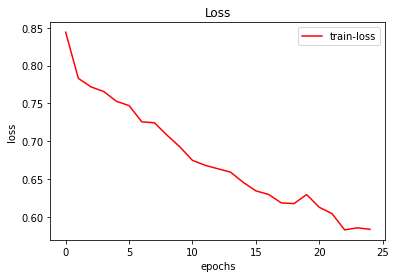

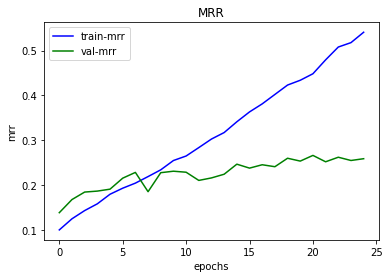

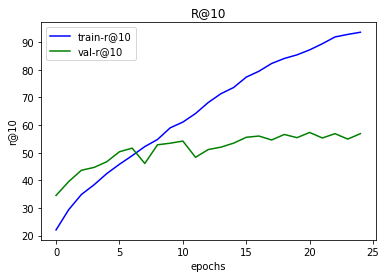

In [ ]:
##############################################################################
# Esta es la parte donde tienes que modificar para poder probar tu
# implementación.
# En general sólo es necesario que modifiques los lugares con "...", pero
# eres libre de hacer tus propias implementaciones de todo lo que aparece.
##############################################################################
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

BATCH_SIZE = 64
LR = 1e-4
EPOCHS = 25
REPORTS_EVERY = 1
CNN_OUT_SIZE = 1024
EMBEDDING_SIZE = 4096
OUT_SIZE = 512
MARGIN = .2
NEGATIVE = 'all' #'all' 'random'

cnn_net = GoogLeNet(n_classes=2, use_aux_logits=False) #nclasses no importan, logits tampoco
img_net = ImageEncoding(cnn_model=cnn_net, cnn_out_size=CNN_OUT_SIZE,
                        out_size=OUT_SIZE)

text_net = TextEncoding(text_embedding_size=EMBEDDING_SIZE, out_size=OUT_SIZE)

optimizer = optim.Adam([{'params': img_net.parameters()}, {'params': text_net.parameters()}], lr=LR)

criterion = TripletLoss(margin=MARGIN, negative=NEGATIVE)
scheduler = StepLR(optimizer, step_size=5, gamma=0.96) # (opcional) optim.lr_scheduler proporciona varios métodos
                # para ajustar el lr según el número de épocas

train_triplets_loader = DataLoader(train_flickr_tripletset, batch_size=BATCH_SIZE,
                                   shuffle=True, num_workers=2)
val_triplets_loader = DataLoader(val_flickr_tripletset, batch_size=BATCH_SIZE,
                                 shuffle=False, num_workers=2)

train_loss, meanrr, r10 = train_for_retrieval(img_net, text_net,
                                              train_triplets_loader,
                                              val_triplets_loader, optimizer,
                                              criterion, scheduler, EPOCHS,
                                              REPORTS_EVERY, norm=False)

plot_results(train_loss, meanrr, 'MRR', r10, 'R@10')

Correct Test!


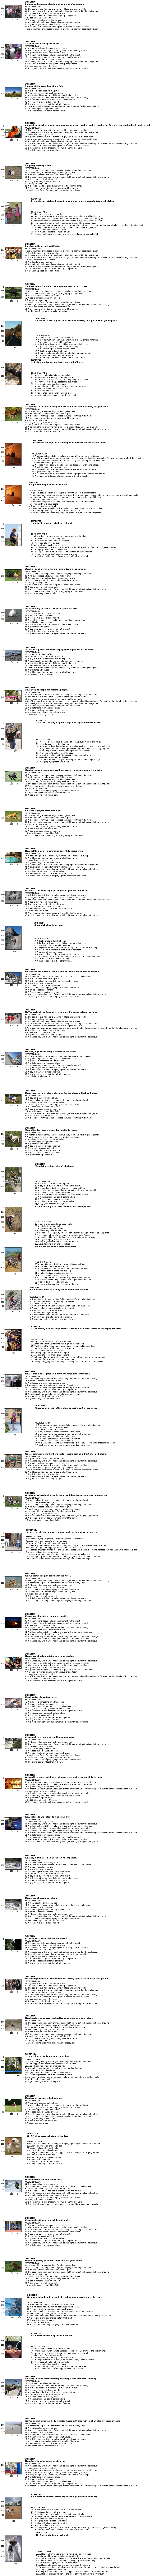

In [ ]:
# Test
from PIL import Image
n_samples = 64

# Tomemos n_samples ejemplos del conjunto de test
samples = torch.stack([test_flickr_tripletset[i][0] for i in range(n_samples)]).cuda()
refs = torch.stack([torch.from_numpy(test_flickr_tripletset[i][1]) for i in range(n_samples)]).cuda()
test_caps = [caps[0] for _, caps in test_flickr_set][:n_samples]

# Computamos las representaciones en el espacio compartido
samples_enc = img_net(samples)['logits']
refs_enc = text_net(refs)['logits']

# Calculemos las distancias a cada uno de los textos de test y rankeamos
dists = torch.cdist(samples_enc.unsqueeze(0), refs_enc.unsqueeze(0), p=2).squeeze(0)
ranks = torch.argsort(dists, dim=1)[:,:10]
r10 = len([i for i in range(len(ranks)) if len(torch.where(ranks[i,:] == i)[0])]) / len(ranks)

# Veamos como se comporta el modelo
print("Correct Test!" if r10 >= .25 else "Failed Test! [R@10]")

# Mostremos las 10 descripciones más cercanas
fig, axs = plt.subplots(nrows=n_samples, figsize=(2,n_samples*5))
for i in range(n_samples):
  axs[i].imshow(Image.open(full_flickr_set.ids[7000+i]))
  axs[i].text(600,0,"EXPECTED:\n{}: {}".format(i, test_caps[i]), fontsize=12, fontweight='bold')
  axs[i].text(600,750,"PREDICTED RANK:\n{}".format('\n'.join([f'{j}: {test_caps[j]}' for j in ranks[i]])), fontsize=12)

## 2d) Opcional: COCO Captions

In [ ]:
##############################################################################
# Toda esta parte es similar a la anterior pero para COCO Captions.
##############################################################################

folder_path = './data/coco-caps'
if not os.path.exists(f'{folder_path}/images/train2014'):
  print('\n*** Descargando y extrayendo COCO Captions, siéntese y relájese unos 20 mins...')
  print('****** Descargando training set...\n')
  !wget http://images.cocodataset.org/zips/train2014.zip -P $folder_path/images
  print('\n********* Extrayendo training set...\n  Si te sale mensaje de colab, dale Ignorar\n')
  !unzip -q $folder_path/images/train2014.zip -d $folder_path/images && rm $folder_path/images/train2014.zip
  print('\n*** Descargando y extrayendo validation set...\n')
  !wget http://images.cocodataset.org/zips/val2014.zip -P $folder_path/images && unzip -q $folder_path/images/val2014.zip -d $folder_path/images && rm $folder_path/images/val2014.zip
  # !wget http://images.cocodataset.org/zips/test2014.zip -P $folder_path/images && unzip -q $folder_path/images/test2014.zip -d $folder_path/images && rm $folder_path/images/test2014.zip
  print('\n*** Descargando y anotaciones de la imágenes...\n')
  !wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip -P $folder_path && unzip -q $folder_path/annotations_trainval2014.zip -d $folder_path && rm $folder_path/images/annotations_trainval2014.zip

transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Resize((32, 32)),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_coco_set = torchvision.datasets.CocoCaptions(root=f'{folder_path}/images/train2014',
                                                   annFile = f'{folder_path}/annotations/captions_train2014.json',
                                                   transform=transform)

val_coco_set = torchvision.datasets.CocoCaptions(root=f'{folder_path}/images/val2014',
                                                 annFile = f'{folder_path}/annotations/captions_val2014.json',
                                                 transform=transform)

# test_coco_set = torchvision.datasets.CocoCaptions(root=f'{folder_path}/images/test2014',
#                                                   transform=transform)

In [ ]:
if not os.path.exists(f'{folder_path}/cap_encodings_512d.pkl'):
  !wget https://s06.imfd.cl/04/CC6204/tareas/tarea4/cap_encodings_512d.pkl -P $folder_path

with open(f'{folder_path}/cap_encodings_512d.pkl', 'rb') as f:
  train_cap_encs, val_cap_encs = pickle.load(f)

train_coco_tripletset = ImageCaptionDataset(train_coco_set, train_cap_encs)
val_coco_tripletset = ImageCaptionDataset(val_coco_set, val_cap_encs)

In [ ]:
BATCH_SIZE = 256
LR = 1e-4
EPOCHS = 10
REPORTS_EVERY = 1
CNN_PREV_SIZE = 1024
EMBEDDING_SIZE = 512
OUT_SIZE = 512
MARGIN = .2

cnn_net = ...
img_net = ImageEncoding(cnn_model=..., cnn_out_size=CNN_PREV_SIZE,
                        out_size=OUT_SIZE)

text_net = TextEncoding(text_embedding_size=EMBEDDING_SIZE, out_size=OUT_SIZE)

optimizer = optim.Adam([{'params': ...}, {'params': ...}], lr=LR)
criterion = TripletLoss(margin=...)

train_triplets_loader = DataLoader(train_coco_tripletset, batch_size=BATCH_SIZE,
                                   shuffle=True, num_workers=2)
val_triplets_loader = DataLoader(val_coco_tripletset, batch_size=BATCH_SIZE,
                                 shuffle=False, num_workers=2)

train_loss, meanrr, r10 = train_for_retrieval(img_net, text_net,
                                                     train_triplets_loader,
                                                     val_triplets_loader,
                                                     optimizer, criterion,
                                                     EPOCHS, REPORTS_EVERY,
                                                     norm=False)

plot_results(train_loss, meanrr, 'MRR', r10, 'R@10')

TypeError: ignored